The Dataset contains the following 12 features:

CustomerID: A unique identifier

Age: The age of the customer

Gender: The gender of the customer

Tenure: The number of months the customer has stayed with the company

Usage Frequency: The number of times the customer has used the service the past month

Support calls: The number of support calls the customer has made the past month

Payment Delay: Number of days the customer has delayed payment the past month

Subscription Type: The type of subscription the customer has

Contract Length: Duration of the contract

Total Spend: The total amount the customer has spent

Last Interaction: Number of days since the last interaction the customer has had with the company

Churn: Whether the customer has churned or not

# Import packages

In [22]:
import winsound
import itertools
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Cleanup

In [23]:
test_set_dirty = pd.read_csv("Datasets/In/customer_churn_dataset-testing-master.csv", sep=",")
training_set_dirty = pd.read_csv("Datasets/In/customer_churn_dataset-training-master.csv", sep=",")

combined_set_dirty = pd.concat([training_set_dirty, test_set_dirty], ignore_index=True)
combined_set_dirty = combined_set_dirty.drop(combined_set_dirty.columns[0], axis=1)

In [24]:
missing_values = combined_set_dirty.isnull().sum()
missing_values

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [25]:
combined_set_dirty[combined_set_dirty.isna().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
combined_set_dirty.dropna(inplace=True)

combined_set_dirty.columns = [col.lower().replace(" ", "_") for col in combined_set_dirty.columns]
combined_set_dirty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505206 entries, 0 to 505206
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                505206 non-null  float64
 1   gender             505206 non-null  object 
 2   tenure             505206 non-null  float64
 3   usage_frequency    505206 non-null  float64
 4   support_calls      505206 non-null  float64
 5   payment_delay      505206 non-null  float64
 6   subscription_type  505206 non-null  object 
 7   contract_length    505206 non-null  object 
 8   total_spend        505206 non-null  float64
 9   last_interaction   505206 non-null  float64
 10  churn              505206 non-null  float64
dtypes: float64(8), object(3)
memory usage: 46.3+ MB


In [27]:
combined_set_dirty[combined_set_dirty.isna().any(axis=1)]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn


In [28]:
numerals = ["age", "tenure", "usage_frequency", "support_calls", "payment_delay", "last_interaction", "churn"]

for col in numerals:
    combined_set_dirty[col] = combined_set_dirty[col].astype(int)

In [29]:
cleaned_set = combined_set_dirty.copy()

# Descriptive Analytics

Summary Statistics for Churned Customers:
                 age         tenure  usage_frequency  support_calls  \
count  280492.000000  280492.000000    280492.000000  280492.000000   
mean       41.872841      31.021683        15.303909       5.281377   
std        13.988755      17.270441         8.737989       3.123577   
min        18.000000       1.000000         1.000000       0.000000   
25%        30.000000      16.000000         8.000000       3.000000   
50%        42.000000      31.000000        15.000000       5.000000   
75%        54.000000      46.000000        23.000000       8.000000   
max        65.000000      60.000000        30.000000      10.000000   

       payment_delay    total_spend  last_interaction     churn  
count  280492.000000  280492.000000     280492.000000  280492.0  
mean       15.991454     538.899354         15.590266       1.0  
std         8.985814     260.016780          8.655404       0.0  
min         0.000000     100.000000          1.000000 

C:\Users\yusuf\AppData\Local\Temp\ipykernel_30820\1215551979.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = cleaned_set.corr()


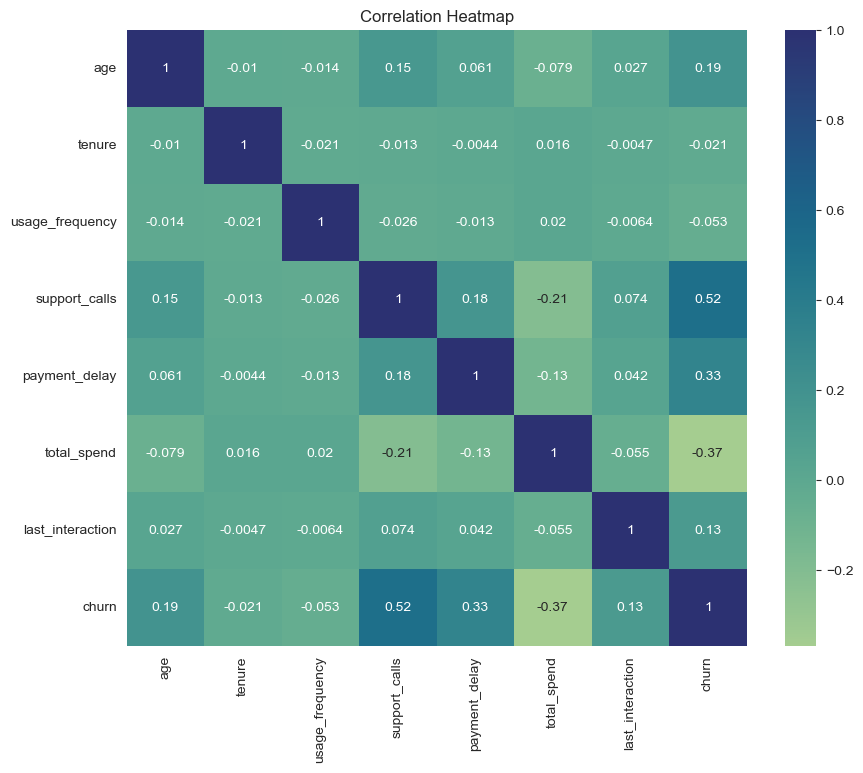

Churn Rate: 55.52032240313852%


In [70]:
# Summary statistics
print("Summary Statistics for Churned Customers:")
print(cleaned_set[cleaned_set['churn'] == 1].describe())
print("\nSummary Statistics for Non-Churned Customers:")
print(cleaned_set[cleaned_set['churn'] == 0].describe())

# Correlation analysis
correlation = cleaned_set.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

# Churn rate
churn_rate = cleaned_set['churn'].mean() * 100
print(f"Churn Rate: {churn_rate}%")

In [31]:
numeric_cols = ["age", "tenure", "usage_frequency", "support_calls", "payment_delay", "last_interaction", "total_spend"]

num_bins = 3

excourse_set = cleaned_set.copy()

for col in numeric_cols:
    excourse_set[col] = pd.cut(cleaned_set[col], num_bins, duplicates='drop')
    print(col)
    for interval in excourse_set[col].cat.categories:
        print(interval)

age
(17.953, 33.667]
(33.667, 49.333]
(49.333, 65.0]
tenure
(0.941, 20.667]
(20.667, 40.333]
(40.333, 60.0]
usage_frequency
(0.971, 10.667]
(10.667, 20.333]
(20.333, 30.0]
support_calls
(-0.01, 3.333]
(3.333, 6.667]
(6.667, 10.0]
payment_delay
(-0.03, 10.0]
(10.0, 20.0]
(20.0, 30.0]
last_interaction
(0.971, 10.667]
(10.667, 20.333]
(20.333, 30.0]
total_spend
(99.1, 400.0]
(400.0, 700.0]
(700.0, 1000.0]


In [32]:
columns = ["age", "gender", "tenure", "usage_frequency", "support_calls", "payment_delay", "subscription_type",
           "contract_length", "total_spend", "last_interaction"]

stacked_data_percent = {}

for col in columns:
    category_counts = excourse_set.groupby([col, "churn"]).size().unstack(fill_value=0)

    category_percent = category_counts.div(category_counts.sum(axis=1), axis=0) * 100
    print(category_percent)
    stacked_data_percent[col] = category_percent

churn                     0          1
age                                   
(17.953, 33.667]  48.003985  51.996015
(33.667, 49.333]  57.166378  42.833622
(49.333, 65.0]    16.496744  83.503256
churn           0          1
gender                      
Female  35.105565  64.894435
Male    52.002869  47.997131
churn                     0          1
tenure                                
(0.941, 20.667]   43.067892  56.932108
(20.667, 40.333]  44.660109  55.339891
(40.333, 60.0]    45.557180  54.442820
churn                     0          1
usage_frequency                       
(0.971, 10.667]   40.165348  59.834652
(10.667, 20.333]  46.572919  53.427081
(20.333, 30.0]    46.431268  53.568732
churn                   0          1
support_calls                       
(-0.01, 3.333]  67.694781  32.305219
(3.333, 6.667]  24.752522  75.247478
(6.667, 10.0]    8.490178  91.509822
churn                  0          1
payment_delay                      
(-0.03, 10.0]  56.567156  43.432844
(10.0,

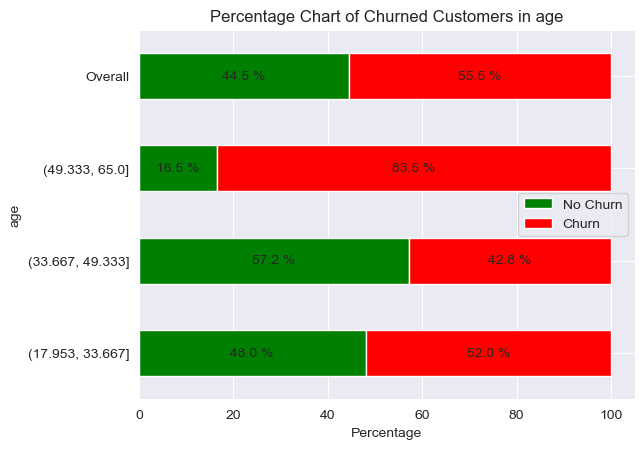

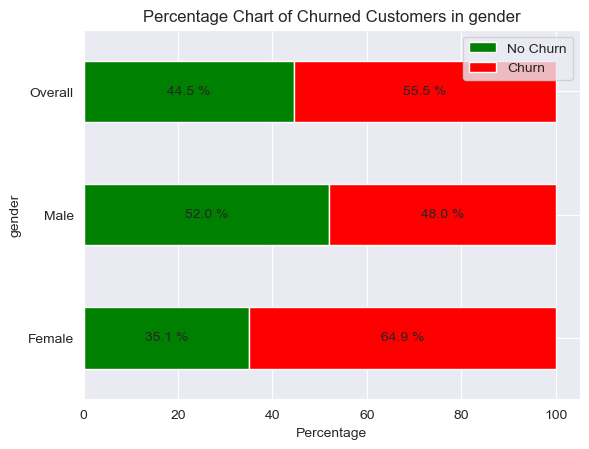

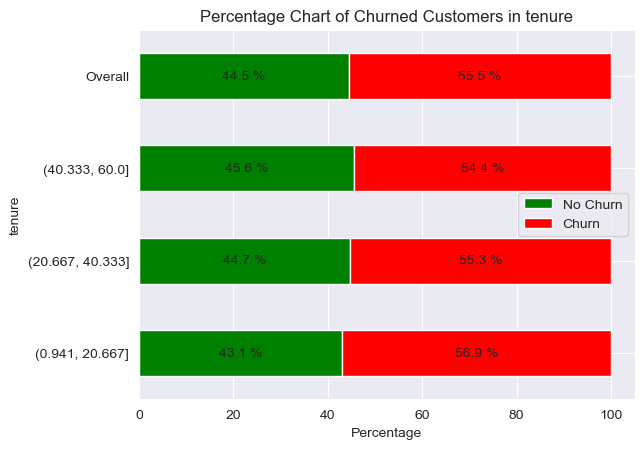

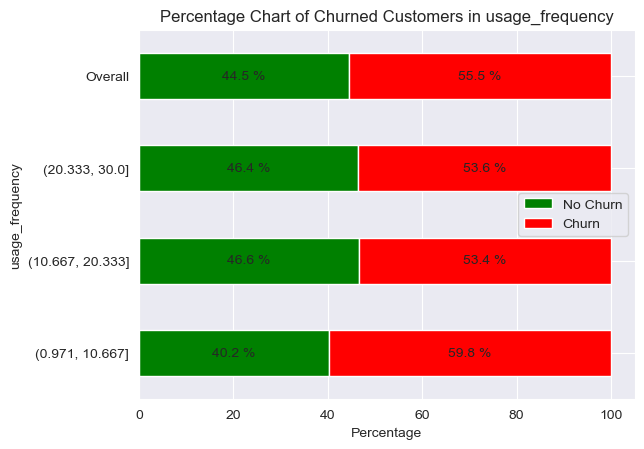

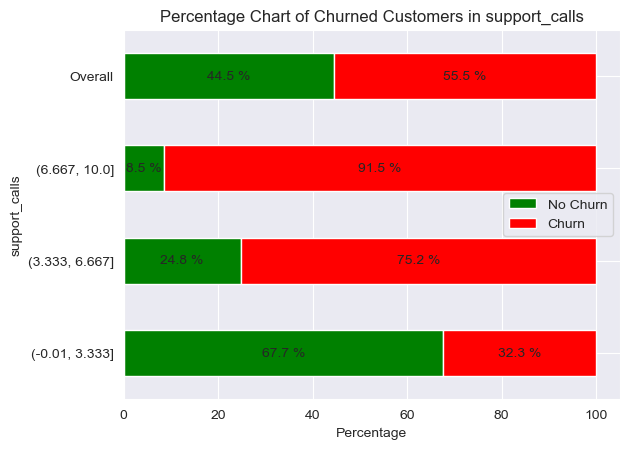

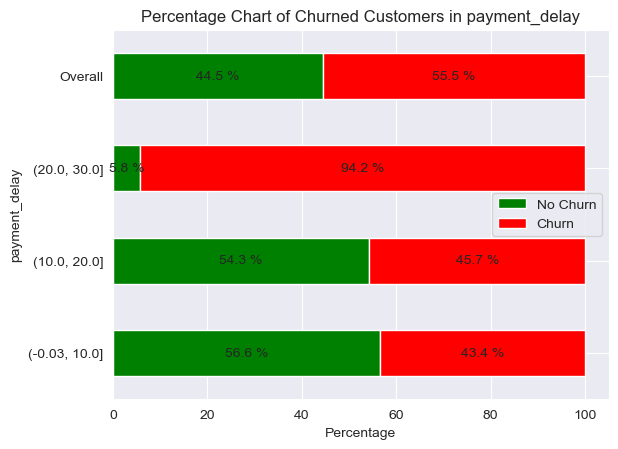

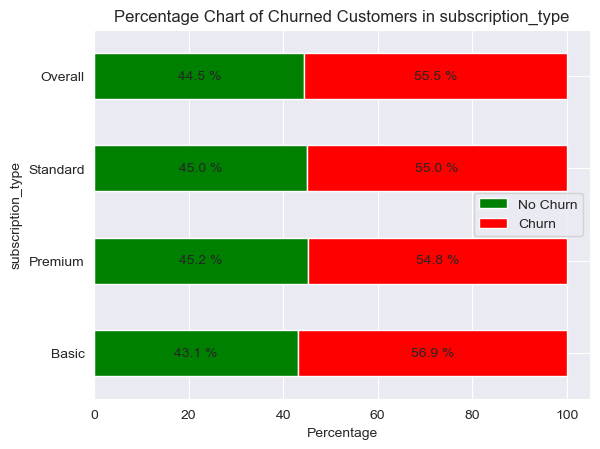

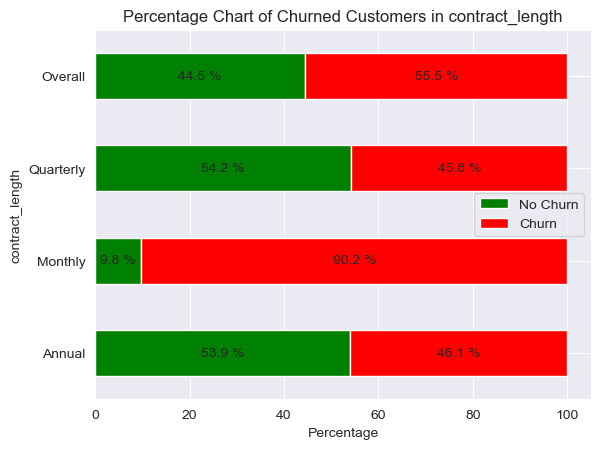

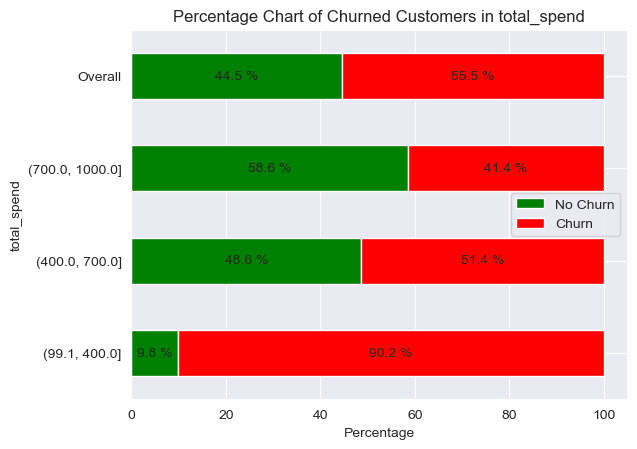

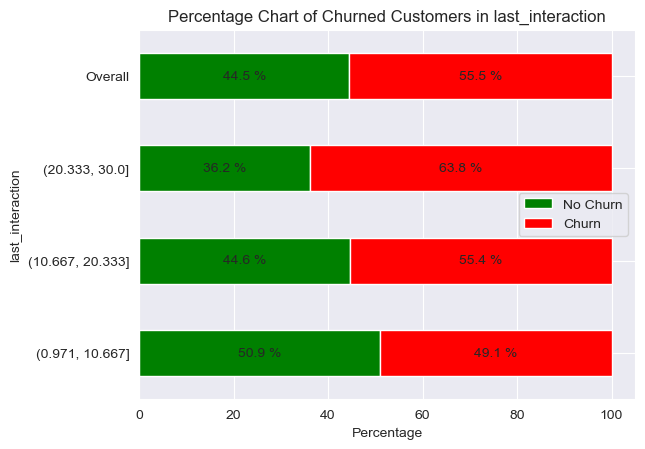

In [33]:
# Calculate the overall churn rate
overall_churn_rate = excourse_set['churn'].mean() * 100

# Add a new row to each DataFrame in stacked_data_percent with the overall churn rate
for col, df in stacked_data_percent.items():
    df.loc['Overall'] = [100 - overall_churn_rate, overall_churn_rate]

colors = {0: 'green', 1: 'red'}
for col, df in stacked_data_percent.items():
    ax = df.plot(kind='barh', stacked=True, color=[colors[churn] for churn in df.columns],
                 title=f'Percentage Chart of Churned Customers in {col}')
    plt.ylabel(col)
    plt.xlabel('Percentage')
    plt.legend(["No Churn", "Churn"], loc='best')

    # Add the percentage values on each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.text(x + width / 2,
                y + height / 2,
                '{:.1f} %'.format(width),
                horizontalalignment='center',
                verticalalignment='center')
    plt.show()

In [34]:
combinations = list(itertools.combinations(columns, 2))

# Analyze each combination
for combination in combinations:
    # Create a multi-index DataFrame
    multi_index_df = excourse_set.set_index(list(combination) + ['churn'])

    # Calculate the size of each group
    grouped_df = multi_index_df.groupby(list(combination) + ['churn']).size()

    # Unstack the DataFrame to get a cross-tabulation
    cross_tab = grouped_df.unstack(fill_value=0)

    # Convert absolute numbers to relative percentages
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

    # Print the cross-tabulation
    print(f"Cross-tabulation for {combination}:")
    print(cross_tab_percent)
    print("\n")

Cross-tabulation for ('age', 'gender'):
churn                            0          1
age              gender                      
(17.953, 33.667] Female  38.025946  61.974054
                 Male    55.880714  44.119286
(33.667, 49.333] Female  46.674686  53.325314
                 Male    64.828696  35.171304
(49.333, 65.0]   Female  13.456105  86.543895
                 Male    19.450720  80.549280


Cross-tabulation for ('age', 'tenure'):
churn                                      0          1
age              tenure                                
(17.953, 33.667] (0.941, 20.667]   46.438193  53.561807
                 (20.667, 40.333]  48.112829  51.887171
                 (40.333, 60.0]    49.270641  50.729359
(33.667, 49.333] (0.941, 20.667]   55.417985  44.582015
                 (20.667, 40.333]  57.593139  42.406861
                 (40.333, 60.0]    58.264728  41.735272
(49.333, 65.0]   (0.941, 20.667]   17.309815  82.690185
                 (20.667, 40.333]  16.208328  

In [67]:
combinations = list(itertools.combinations(columns, 3))

# Analyze each combination
for combination in combinations:
    # Create a multi-index DataFrame
    multi_index_df = excourse_set.set_index(list(combination) + ['churn'])

    # Calculate the size of each group
    grouped_df = multi_index_df.groupby(list(combination) + ['churn']).size()

    # Unstack the DataFrame to get a cross-tabulation
    cross_tab = grouped_df.unstack(fill_value=0)

    # Convert absolute numbers to relative percentages
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

    # Print the cross-tabulation
    print(f"Cross-tabulation for {combination}:")
    print(cross_tab_percent)
    print("\n") 

Cross-tabulation for ('age', 'gender', 'tenure'):
churn                                             0          1
age              gender tenure                                
(17.953, 33.667] Female (0.941, 20.667]   36.304143  63.695857
                        (20.667, 40.333]  38.302639  61.697361
                        (40.333, 60.0]    39.308211  60.691789
                 Male   (0.941, 20.667]   54.665294  45.334706
                        (20.667, 40.333]  55.839340  44.160660
                        (40.333, 60.0]    56.960874  43.039126
(33.667, 49.333] Female (0.941, 20.667]   44.749403  55.250597
                        (20.667, 40.333]  47.076472  52.923528
                        (40.333, 60.0]    47.990544  52.009456
                 Male   (0.941, 20.667]   63.435513  36.564487
                        (20.667, 40.333]  65.198525  34.801475
                        (40.333, 60.0]    65.654152  34.345848
(49.333, 65.0]   Female (0.941, 20.667]   14.137621  85.862379
     

# Predictive Analytics

In [36]:
prepared_set = cleaned_set.copy()

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False)

# Identify categorical columns
categorical_cols = ['gender', 'subscription_type', 'contract_length']

# Fit and transform the data, converting it into a DataFrame
prepared_set_encoded = pd.DataFrame(encoder.fit_transform(prepared_set[categorical_cols]))

# Get feature names from the encoder and assign them as column names
prepared_set_encoded.columns = encoder.get_feature_names_out(categorical_cols)
 
# Drop the original categorical columns
prepared_set.drop(categorical_cols, axis=1, inplace=True)

# Reset the indices of the dataframes
prepared_set = prepared_set.reset_index(drop=True)
prepared_set_encoded = prepared_set_encoded.reset_index(drop=True)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
prepared_set = pd.concat([prepared_set, prepared_set_encoded], axis=1)

prepared_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505206 entries, 0 to 505205
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         505206 non-null  int32  
 1   tenure                      505206 non-null  int32  
 2   usage_frequency             505206 non-null  int32  
 3   support_calls               505206 non-null  int32  
 4   payment_delay               505206 non-null  int32  
 5   total_spend                 505206 non-null  float64
 6   last_interaction            505206 non-null  int32  
 7   churn                       505206 non-null  int32  
 8   gender_Female               505206 non-null  float64
 9   gender_Male                 505206 non-null  float64
 10  subscription_type_Basic     505206 non-null  float64
 11  subscription_type_Premium   505206 non-null  float64
 12  subscription_type_Standard  505206 non-null  float64
 13  contract_lengt

## Primitive Approach

In [37]:
primitive_set = prepared_set.copy()

X = primitive_set.drop('churn', axis=1)
y = primitive_set['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RidgeClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [38]:
primitive_mse = mean_squared_error(y_test, y_pred)
primitive_mae = mean_absolute_error(y_test, y_pred)
primitive_r2 = r2_score(y_test, y_pred)
primitive_accuracy = accuracy_score(y_test, y_pred)
primitive_precision = precision_score(y_test, y_pred)
primitive_recall = recall_score(y_test, y_pred)
primitive_f1 = f1_score(y_test, y_pred)
primitive_roc_auc = roc_auc_score(y_test, y_pred)

print(
    f"MSE: {primitive_mse}\nMAE: {primitive_mae}\nR2: {primitive_r2}\nAccuracy: {primitive_accuracy}\nPrecision: {primitive_precision}\nRecall: {primitive_recall}\nF1 Score: {primitive_f1}\nROC AUC: {primitive_roc_auc}")

MSE: 0.16038874923299223
MAE: 0.16038874923299223
R2: 0.35063657750040267
Accuracy: 0.8396112507670078
Precision: 0.8822728231886282
Recall: 0.8203920729205687
F1 Score: 0.8502079674646456
ROC AUC: 0.8419783445459206


# My Model
## Define Target and Feauture Variables & Split and Scale Set
Split the data into training, validation, and test sets, then, standardise the features

In [39]:
better_model = prepared_set.copy()

# Define Target and feature variables
y = better_model['churn'].values
X = better_model.drop(['churn'], axis=1)

# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

In [40]:
def beep():
    duration = 5000
    freq = 1000
    winsound.Beep(freq, duration)

### Train and Evaluate Models

Perform hyperparameter tuning for the RandomForest model using randomised search. Print the best hyperparameters and the corresponding Recall(on subset of training set(Cross-Validation)) score.

In [41]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf_model = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=3, verbose=2,random_state=42, n_jobs=-1, scoring='recall')

rf_random.fit(X_train, y_train)

print(rf_random.best_score_) # 0.9959059371040283
print(rf_random.best_params_) # {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
# Runtime 2h 51m 14s
beep()

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.9959059369514112
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 80, 'bootstrap': False}


Perform hyperparameter tuning for the XGBoost model using randomised search. Print the best hyperparameters and the corresponding Recall(on subset of training set(Cross-Validation)) score.

In [42]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.20, 0.30],
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 10, 100],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42)

xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=300, cv=3, verbose=2, n_jobs=-1, scoring='recall')

xgb_random.fit(X_train, y_train)

print(xgb_random.best_score_) # 0.9973181753786369
print(xgb_random.best_params_) # {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
# Runtime 1h 47m 7s
beep()

Fitting 3 folds for each of 300 candidates, totalling 900 fits
0.9973181753786369
{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


Perform hyperparameter tuning for the LightGBM using grid search. Print the best hyperparameters and the corresponding Recall(on subset of training set(Cross-Validation)) score.

In [43]:
# Define the parameter lgbm_grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
lgbm_model = lgb.LGBMClassifier()

# Create the lgbm_grid search object
lgbm_grid = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='recall')

# Fit the lgbm_grid search object to the data
lgbm_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(lgbm_grid.best_params_) # {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 93}
print(lgbm_grid.best_score_) # 0.9991155677841
# Runtime 8m 31s 633ms
beep()

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 93}
0.9991155677841


Perform hyperparameter tuning for the Decision Tree model using grid search. Print the best hyperparameters and the corresponding Recall(on subset of training set(Cross-Validation)) score

In [44]:
# Define the parameter tree_grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
decTree_model = DecisionTreeClassifier()

#Create the tree_grid search object
tree_grid = GridSearchCV(decTree_model, param_grid, cv=5, scoring="recall", verbose=1)

# fit the tree_grid search object to the data
tree_grid.fit(X_train, y_train)

#Print the best parameters and the corresponding score
print(tree_grid.best_params_)  # {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
print(tree_grid.best_score_)  # 0.9912056159258545
# Runtime 7m 22s 647ms
beep()

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9911842179230016


In [45]:
y_pred_rf = rf_random.best_estimator_.predict(X_val)
y_pred_xgb = xgb_random.best_estimator_.predict(X_val)
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_val)
y_pred_tree = tree_grid.best_estimator_.predict(X_val)

In [46]:
#Accuracy, Precision, Recall, F1 Score and ROC AUC
# Calculate the performance metrics
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_precision = precision_score(y_val, y_pred_rf)
rf_recall = recall_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf)
rf_roc_auc = roc_auc_score(y_val, y_pred_rf)

xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
xgb_precision = precision_score(y_val, y_pred_xgb)
xgb_recall = recall_score(y_val, y_pred_xgb)
xgb_f1 = f1_score(y_val, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_val, y_pred_xgb)

lgbm_accuracy = accuracy_score(y_val, y_pred_lgbm)
lgbm_precision = precision_score(y_val, y_pred_lgbm)
lgbm_recall = recall_score(y_val, y_pred_lgbm)
lgbm_f1 = f1_score(y_val, y_pred_lgbm)
lgbm_roc_auc = roc_auc_score(y_val, y_pred_lgbm)

tree_accuracy = accuracy_score(y_val, y_pred_tree)
tree_precision = precision_score(y_val, y_pred_tree)
tree_recall = recall_score(y_val, y_pred_tree)
tree_f1 = f1_score(y_val, y_pred_tree)
tree_roc_auc = roc_auc_score(y_val, y_pred_tree)

models = ['Random Forest (Validation Set)', 'XGBoost (Validation Set)', 'LightGBM (Validation Set)', 'Decision Tree (Validation Set)']
accuracy_values = [rf_accuracy, xgb_accuracy, lgbm_accuracy, tree_accuracy]
precision_values = [rf_precision, xgb_precision, lgbm_precision, tree_precision]
recall_values = [rf_recall, xgb_recall, lgbm_recall, tree_recall]
f1_values = [rf_f1, xgb_f1, lgbm_f1, tree_f1]
roc_auc_values = [rf_roc_auc, xgb_roc_auc, lgbm_roc_auc, tree_roc_auc]

In [47]:
def print_values(values, models, title):
    print(title)
    for model, value in zip(models, values):
        print(f"{model}: {value}")

def plot_values(values, title, models, ylabel):
    plt.figure(figsize=(15, 6))
    sns.barplot(x=models, y=values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

In [48]:
print_values(accuracy_values, models, 'Comparison of Accuracy')
print_values(precision_values, models, 'Comparison of Precision')
print_values(recall_values, models, 'Comparison of Recall')
print_values(f1_values, models, 'Comparison of F1 Score')
print_values(roc_auc_values, models, 'Comparison of ROC AUC')

Comparison of Accuracy
Random Forest (Validation Set): 0.9347051761600969
XGBoost (Validation Set): 0.9347944716189267
LightGBM (Validation Set): 0.935439383266031
Decision Tree (Validation Set): 0.9320461558304973
Comparison of Precision
Random Forest (Validation Set): 0.8967035792924991
XGBoost (Validation Set): 0.8966675236197699
LightGBM (Validation Set): 0.8965589155370177
Decision Tree (Validation Set): 0.8966793245536075
Comparison of Recall
Random Forest (Validation Set): 0.9972473456547385
XGBoost (Validation Set): 0.9974797125799878
LightGBM (Validation Set): 0.9989454116469453
Decision Tree (Validation Set): 0.9918671576162729
Comparison of F1 Score
Random Forest (Validation Set): 0.9443066897981636
XGBoost (Validation Set): 0.9443908547833002
LightGBM (Validation Set): 0.9449869378852056
Decision Tree (Validation Set): 0.9418743794077961
Comparison of ROC AUC
Random Forest (Validation Set): 0.9269625440001273
XGBoost (Validation Set): 0.9270341274136921
LightGBM (Validation

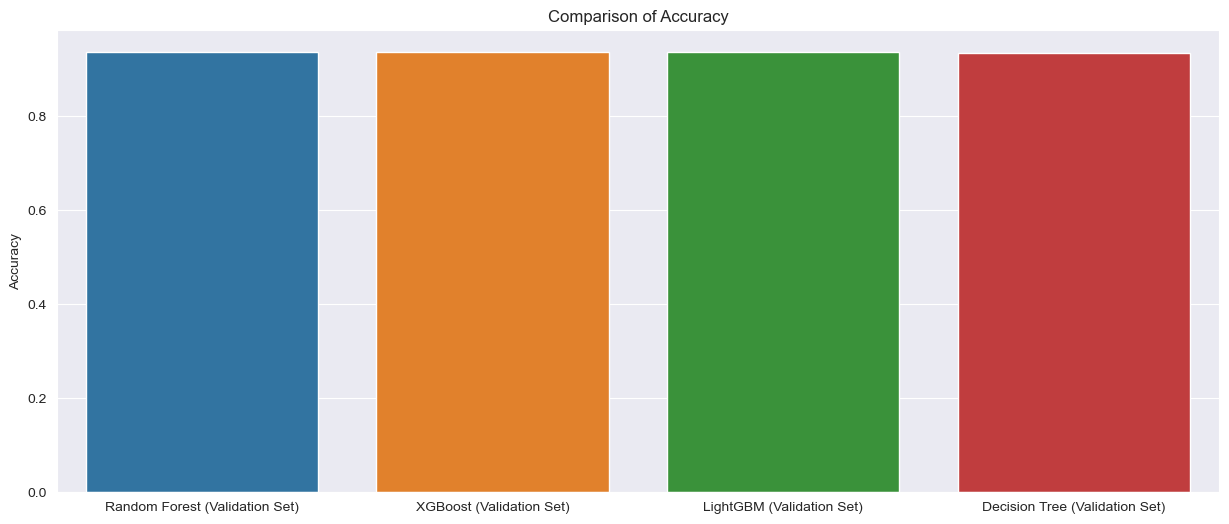

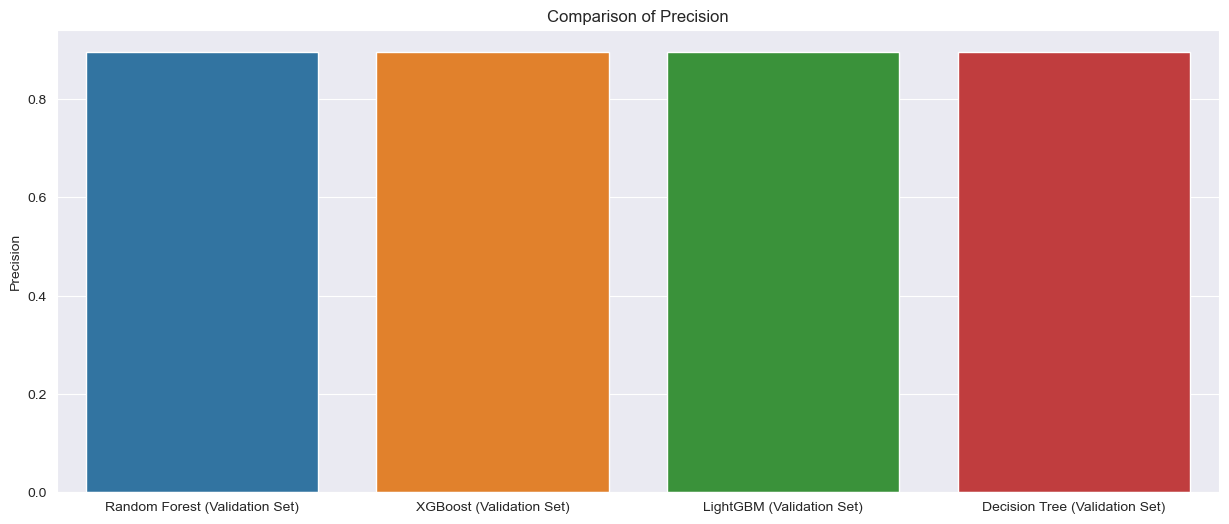

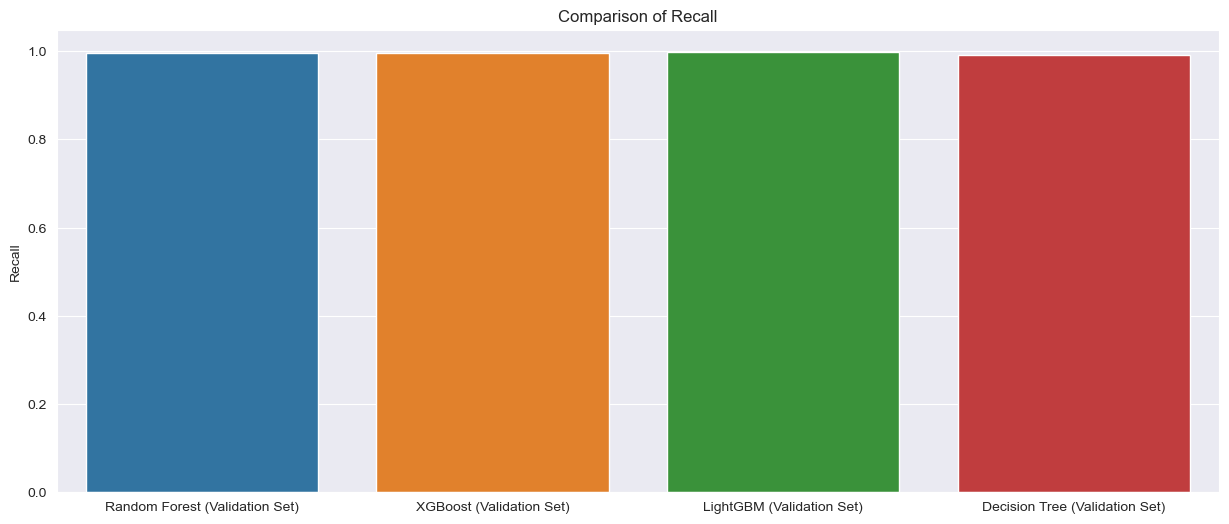

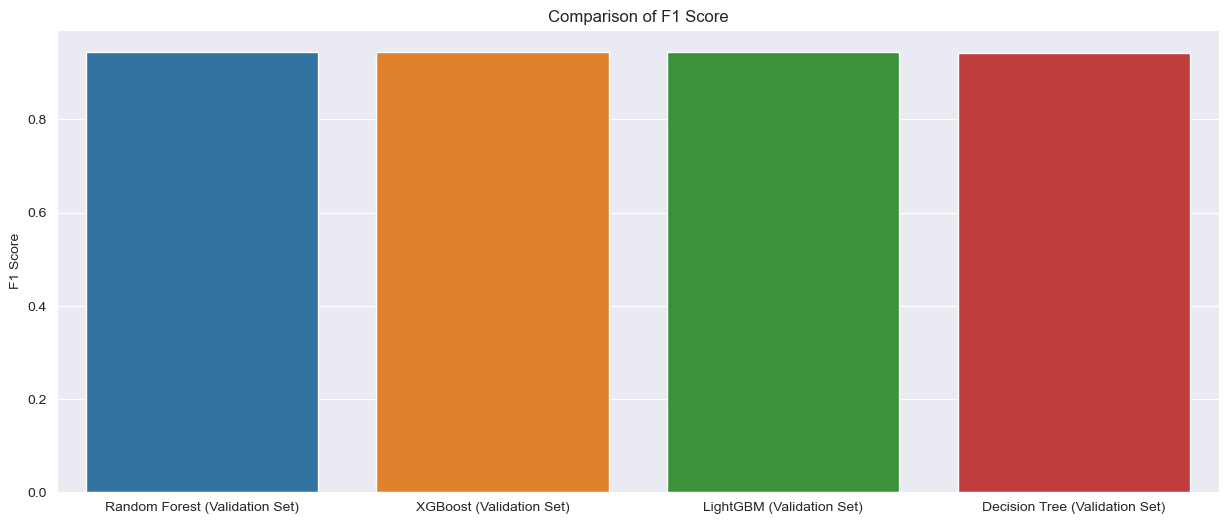

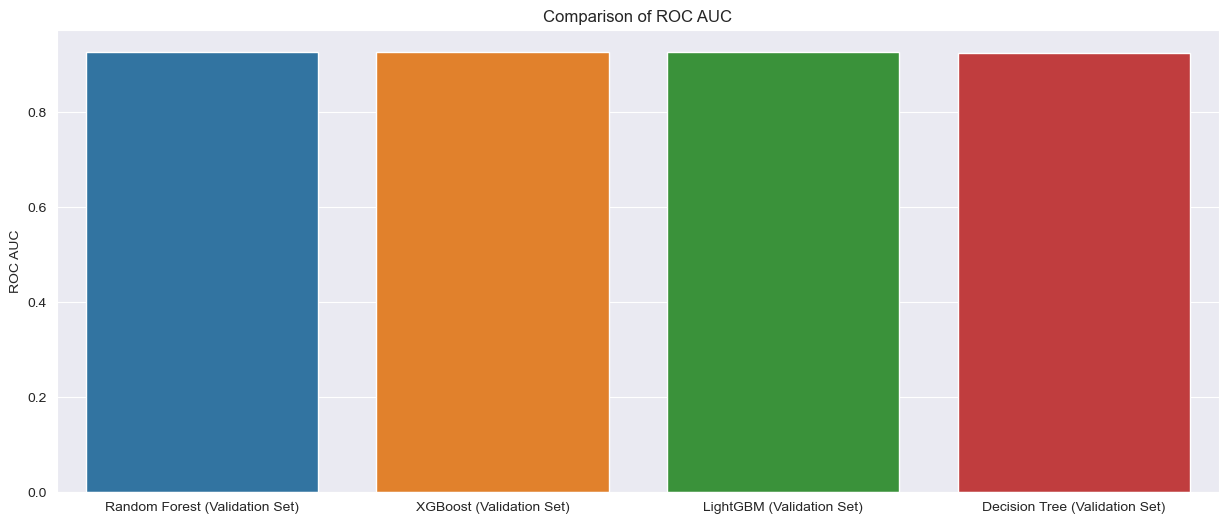

In [49]:
plot_values(accuracy_values, 'Comparison of Accuracy', models, 'Accuracy')
plot_values(precision_values, 'Comparison of Precision', models, 'Precision')
plot_values(recall_values, 'Comparison of Recall', models, 'Recall')
plot_values(f1_values, 'Comparison of F1 Score', models, 'F1 Score')
plot_values(roc_auc_values, 'Comparison of ROC AUC', models, 'ROC AUC')

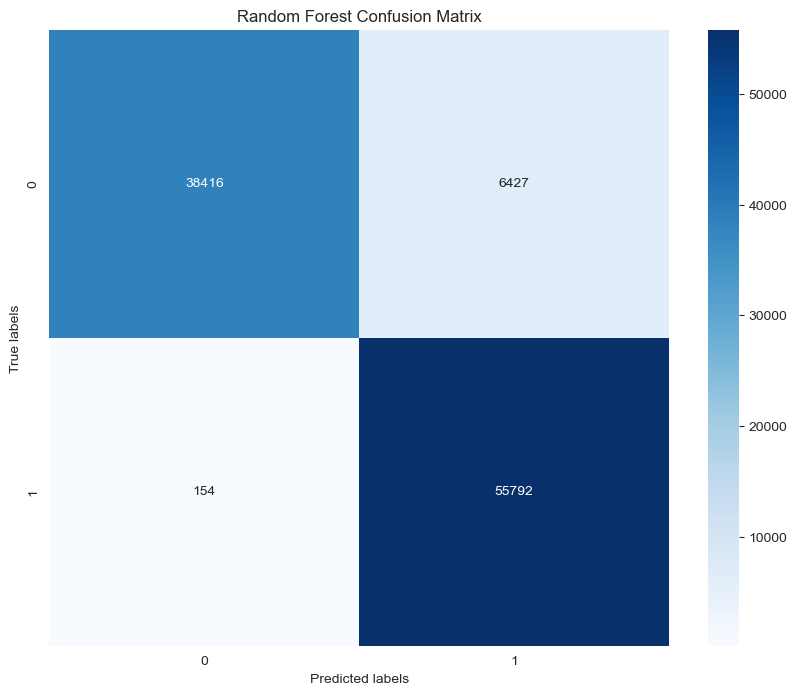

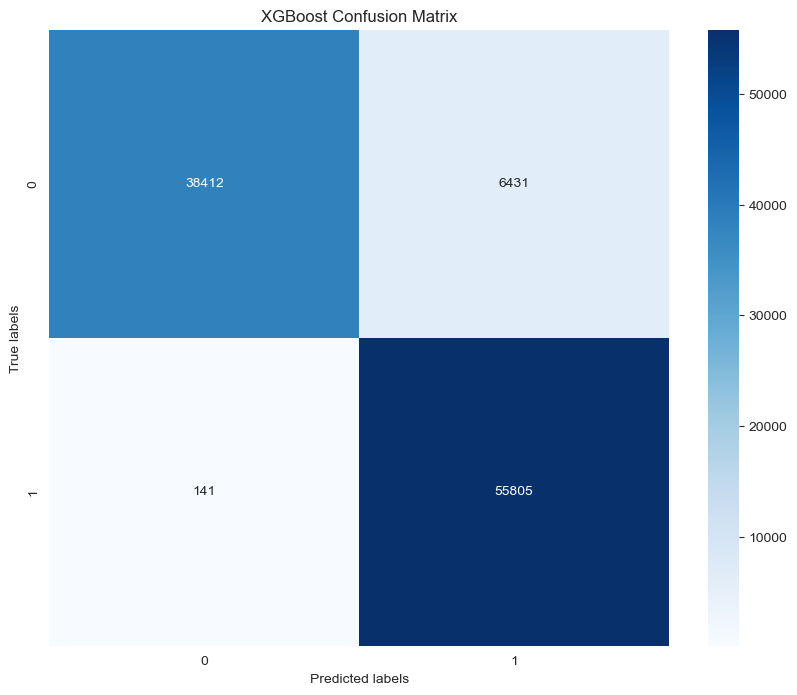

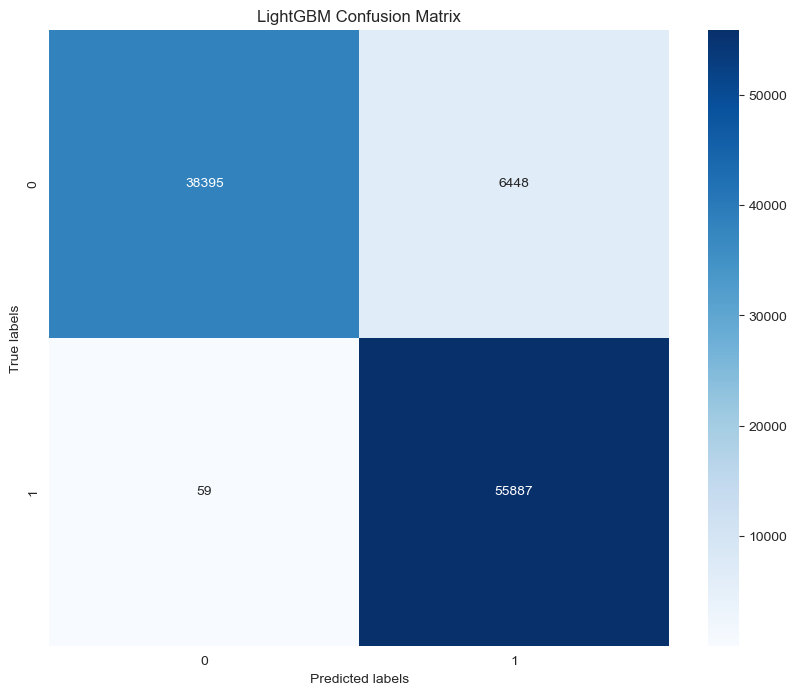

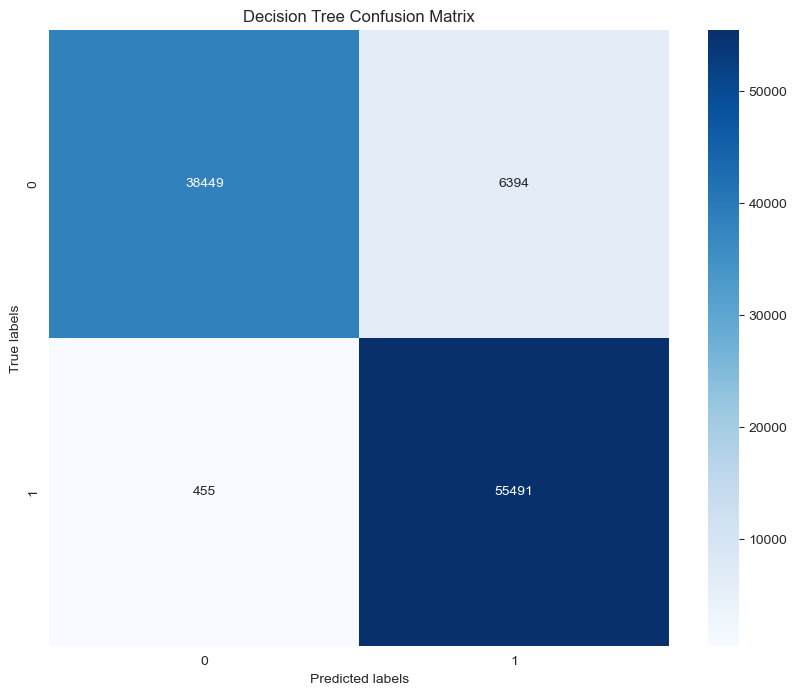

In [50]:
plot_confusion_matrix(y_val, y_pred_rf, 'Random Forest Confusion Matrix')
plot_confusion_matrix(y_val, y_pred_xgb, 'XGBoost Confusion Matrix')
plot_confusion_matrix(y_val, y_pred_lgbm, 'LightGBM Confusion Matrix')
plot_confusion_matrix(y_val, y_pred_tree, 'Decision Tree Confusion Matrix')

Implement the Stacking Classifier using the best models and hyperparameters obtained from the previous steps.

In [51]:
rf_best_params = {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 80, 'bootstrap': False}
xgb_best_params = {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
lgbm_best_params = {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 93}
tree_best_params = {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2}

base_models = [
    ('Random Forest', RandomForestClassifier(**rf_best_params)),
    ('XGBoost', xgb.XGBClassifier(**xgb_best_params)),
    ('LightGBM', lgb.LGBMClassifier(**lgbm_best_params)),
    ('Decision Tree', DecisionTreeClassifier(**tree_best_params))
]

meta_model = lgb.LGBMClassifier()

stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, verbose=2)

In [52]:
stacked_model.fit(X_train, y_train)
beep()

In [53]:
rf_model = RandomForestClassifier(**rf_best_params)
rf_model.fit(X_train, y_train)
beep()

In [54]:
xgb_model = xgb.XGBClassifier(**xgb_best_params)
xgb_model.fit(X_train, y_train)
beep()

In [55]:
lgbm_model = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_model.fit(X_train, y_train)
beep()

In [56]:
decTree_model = DecisionTreeClassifier(**tree_best_params)
decTree_model.fit(X_train, y_train)
beep()

# Evaluate all the models on the validation set

In [57]:
# Predict validation set and calculate performance matrices
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_pred_lgbm = lgbm_model.predict(X_val)
y_val_pred_tree = decTree_model.predict(X_val)
y_val_stack = stacked_model.predict(X_val)

# Calculate the performance metrics
stack_accuracy = accuracy_score(y_val, y_val_stack)
stack_precision = precision_score(y_val, y_val_stack)
stack_recall = recall_score(y_val, y_val_stack)
stack_f1 = f1_score(y_val, y_val_stack)
stack_roc_auc = roc_auc_score(y_val, y_val_stack)

rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)
rf_roc_auc = roc_auc_score(y_val, y_val_pred_rf)

xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
xgb_precision = precision_score(y_val, y_val_pred_xgb)
xgb_recall = recall_score(y_val, y_val_pred_xgb)
xgb_f1 = f1_score(y_val, y_val_pred_xgb)
xgb_roc_auc = roc_auc_score(y_val, y_val_pred_xgb)

lgbm_accuracy = accuracy_score(y_val, y_val_pred_lgbm)
lgbm_precision = precision_score(y_val, y_val_pred_lgbm)
lgbm_recall = recall_score(y_val, y_val_pred_lgbm)
lgbm_f1 = f1_score(y_val, y_val_pred_lgbm)
lgbm_roc_auc = roc_auc_score(y_val, y_val_pred_lgbm)

tree_accuracy = accuracy_score(y_val, y_val_pred_tree)
tree_precision = precision_score(y_val, y_val_pred_tree)
tree_recall = recall_score(y_val, y_val_pred_tree)
tree_f1 = f1_score(y_val, y_val_pred_tree)
tree_roc_auc = roc_auc_score(y_val, y_val_pred_tree)

models = ['Stacking (Validation Set)', 'Random Forest (Validation Set)', 'XGBoost (Validation Set)', 'LightGBM (Validation Set)', 'Decision Tree (Validation Set)']
accuracy_values = [stack_accuracy, rf_accuracy, xgb_accuracy, lgbm_accuracy, tree_accuracy]
precision_values = [stack_precision, rf_precision, xgb_precision, lgbm_precision, tree_precision]
recall_values = [stack_recall, rf_recall, xgb_recall, lgbm_recall, tree_recall]
f1_values = [stack_f1, rf_f1, xgb_f1, lgbm_f1, tree_f1]
roc_auc_values = [stack_roc_auc, rf_roc_auc, xgb_roc_auc, lgbm_roc_auc, tree_roc_auc]

In [58]:
print_values(accuracy_values, models, 'Comparison of Accuracy')
print_values(precision_values, models, 'Comparison of Precision')
print_values(recall_values, models, 'Comparison of Recall')
print_values(f1_values, models, 'Comparison of F1 Score')
print_values(roc_auc_values, models, 'Comparison of ROC AUC')

Comparison of Accuracy
Stacking (Validation Set): 0.9356576610542817
Random Forest (Validation Set): 0.9346654892895058
XGBoost (Validation Set): 0.9347944716189267
LightGBM (Validation Set): 0.935439383266031
Decision Tree (Validation Set): 0.9320560775481451
Comparison of Precision
Stacking (Validation Set): 0.896315764170446
Random Forest (Validation Set): 0.8967096909006156
XGBoost (Validation Set): 0.8966675236197699
LightGBM (Validation Set): 0.8965589155370177
Decision Tree (Validation Set): 0.8966297217824022
Comparison of Recall
Stacking (Validation Set): 0.99973188431702
Random Forest (Validation Set): 0.9971579737604118
XGBoost (Validation Set): 0.9974797125799878
LightGBM (Validation Set): 0.9989454116469453
Decision Tree (Validation Set): 0.9919565295105995
Comparison of F1 Score
Stacking (Validation Set): 0.9452035117070986
Random Forest (Validation Set): 0.9442700090555946
XGBoost (Validation Set): 0.9443908547833002
LightGBM (Validation Set): 0.9449869378852056
Decision

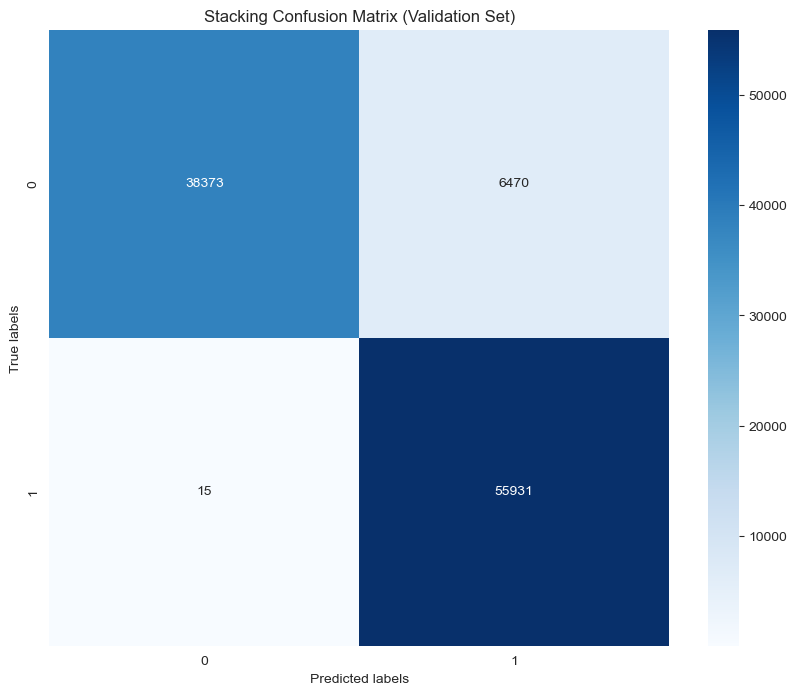

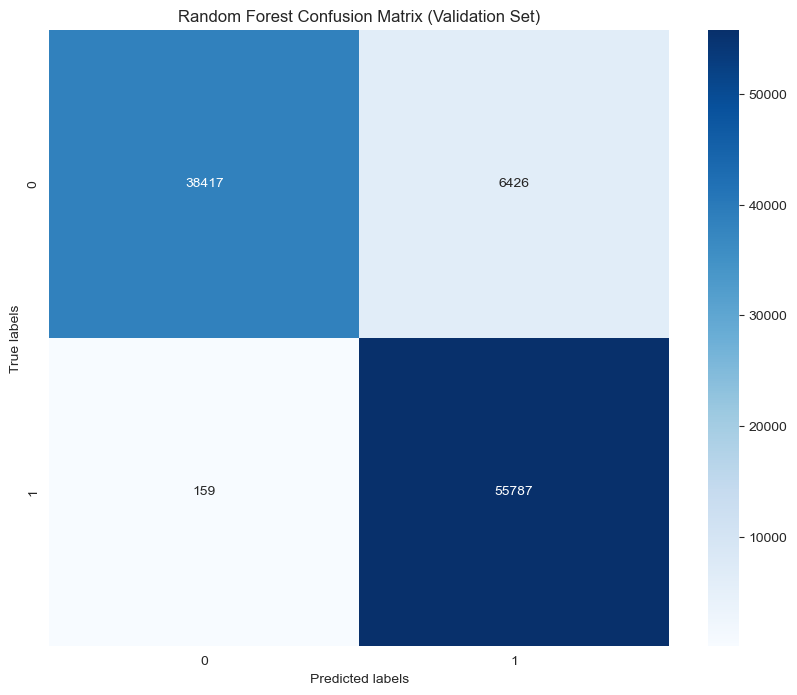

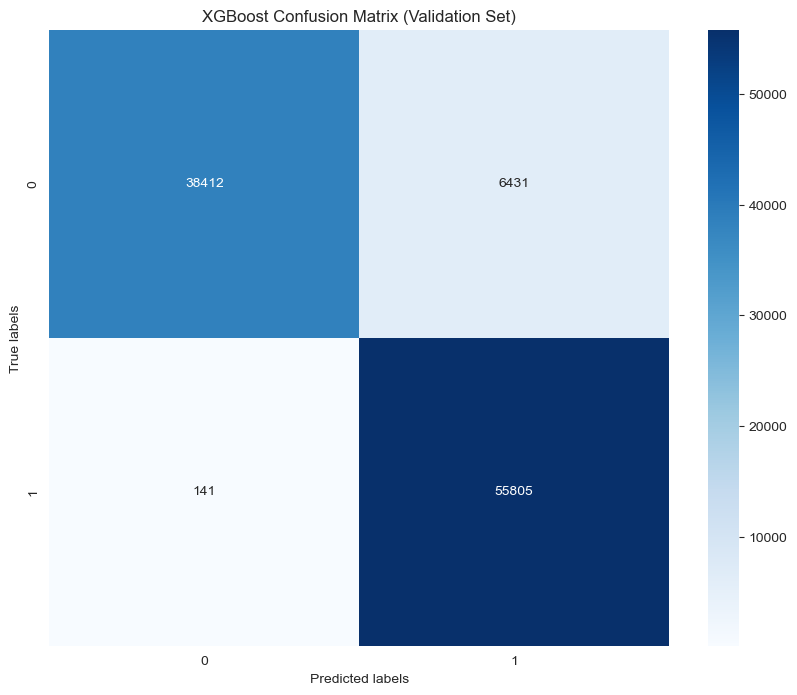

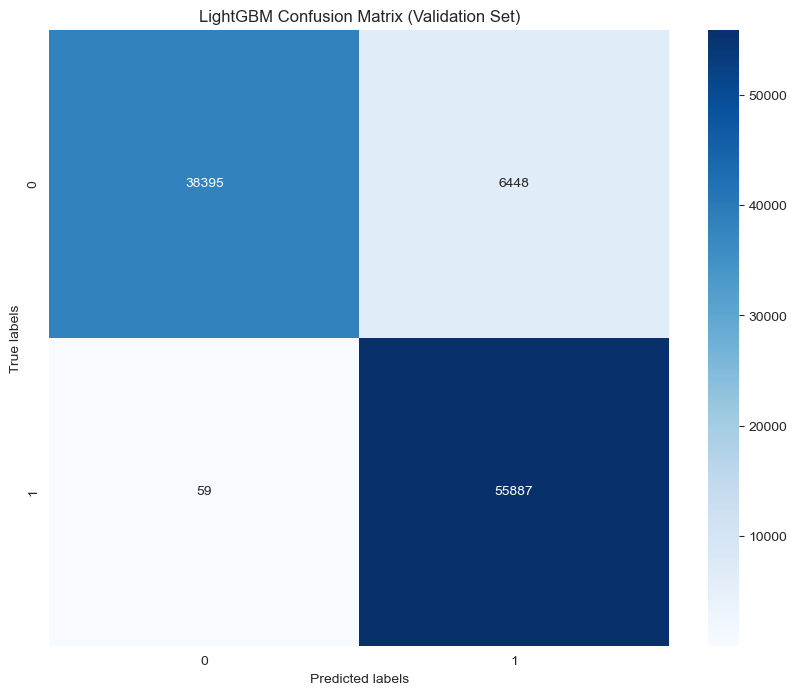

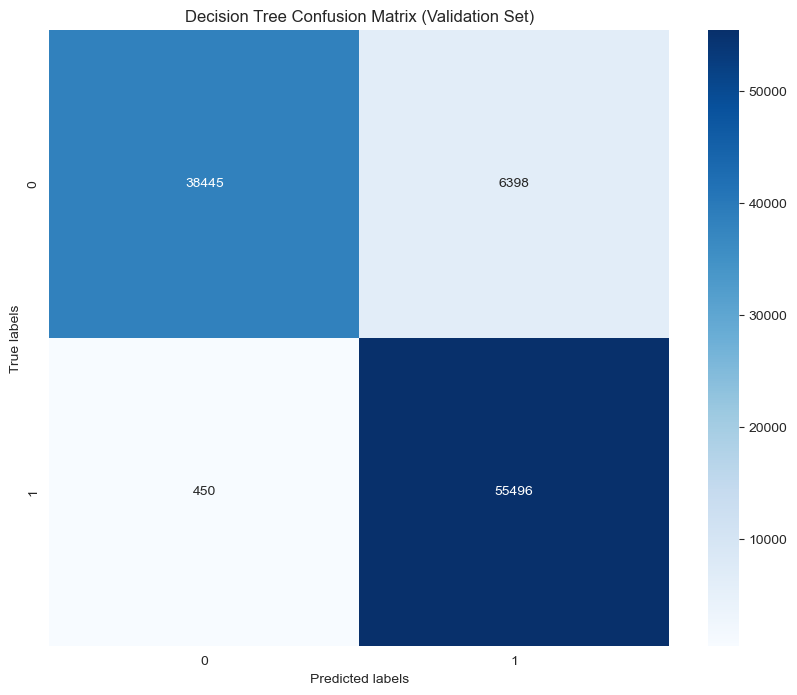

In [59]:
plot_confusion_matrix(y_val, y_val_stack, 'Stacking Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_val, y_val_pred_rf, 'Random Forest Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_val, y_val_pred_xgb, 'XGBoost Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_val, y_val_pred_lgbm, 'LightGBM Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_val, y_val_pred_tree, 'Decision Tree Confusion Matrix (Validation Set)')

# Evaluate the models on the test set

In [60]:
# Predict test set and calculate performance matrices
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_lgbm = lgbm_model.predict(X_test)
y_test_pred_tree = decTree_model.predict(X_test)
y_test_stack = stacked_model.predict(X_test)

# Calculate the performance metrics
stack_accuracy = accuracy_score(y_test, y_test_stack)
stack_precision = precision_score(y_test, y_test_stack)
stack_recall = recall_score(y_test, y_test_stack)
stack_f1 = f1_score(y_test, y_test_stack)
stack_roc_auc = roc_auc_score(y_test, y_test_stack)

rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf)
rf_recall = recall_score(y_test, y_test_pred_rf)
rf_f1 = f1_score(y_test, y_test_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_test_pred_rf)

xgb_accuracy = accuracy_score(y_test, y_test_pred_xgb)
xgb_precision = precision_score(y_test, y_test_pred_xgb)
xgb_recall = recall_score(y_test, y_test_pred_xgb)
xgb_f1 = f1_score(y_test, y_test_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_test_pred_xgb)

lgbm_accuracy = accuracy_score(y_test, y_test_pred_lgbm)
lgbm_precision = precision_score(y_test, y_test_pred_lgbm)
lgbm_recall = recall_score(y_test, y_test_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_test_pred_lgbm)
lgbm_roc_auc = roc_auc_score(y_test, y_test_pred_lgbm)

tree_accuracy = accuracy_score(y_test, y_test_pred_tree)
tree_precision = precision_score(y_test, y_test_pred_tree)
tree_recall = recall_score(y_test, y_test_pred_tree)
tree_f1 = f1_score(y_test, y_test_pred_tree)
tree_roc_auc = roc_auc_score(y_test, y_test_pred_tree)

models = ['Stacking (Test Set)', 'Random Forest (Test Set)', 'XGBoost (Test Set)', 'LightGBM (Test Set)', 'Decision Tree (Test Set)']
accuracy_values = [stack_accuracy, rf_accuracy, xgb_accuracy, lgbm_accuracy, tree_accuracy]
precision_values = [stack_precision, rf_precision, xgb_precision, lgbm_precision, tree_precision]
recall_values = [stack_recall, rf_recall, xgb_recall, lgbm_recall, tree_recall]
f1_values = [stack_f1, rf_f1, xgb_f1, lgbm_f1, tree_f1]
roc_auc_values = [stack_roc_auc, rf_roc_auc, xgb_roc_auc, lgbm_roc_auc, tree_roc_auc]

In [61]:
print_values(accuracy_values, models, 'Comparison of Accuracy')
print_values(precision_values, models, 'Comparison of Precision')
print_values(recall_values, models, 'Comparison of Recall')
print_values(f1_values, models, 'Comparison of F1 Score')
print_values(roc_auc_values, models, 'Comparison of ROC AUC')

Comparison of Accuracy
Stacking (Test Set): 0.9353597867539357
Random Forest (Test Set): 0.934251329488922
XGBoost (Test Set): 0.9343964846069596
LightGBM (Test Set): 0.9350364867183067
Decision Tree (Test Set): 0.931123896491205
Comparison of Precision
Stacking (Test Set): 0.8961083126102574
Random Forest (Test Set): 0.8963444527336673
XGBoost (Test Set): 0.8963011889035667
LightGBM (Test Set): 0.8962817171126124
Decision Tree (Test Set): 0.8960302660064733
Comparison of Recall
Stacking (Test Set): 0.9997510166818823
Random Forest (Test Set): 0.997166332712851
XGBoost (Test Set): 0.997522023167305
LightGBM (Test Set): 0.998849934197266
Decision Tree (Test Set): 0.9912500148204356
Comparison of F1 Score
Stacking (Test Set): 0.9450966986286784
Random Forest (Test Set): 0.9440712116875171
XGBoost (Test Set): 0.9442065865743415
LightGBM (Test Set): 0.9447902297883795
Decision Tree (Test Set): 0.9412380593192194
Comparison of ROC AUC
Stacking (Test Set): 0.9271579731202446
Random Forest (T

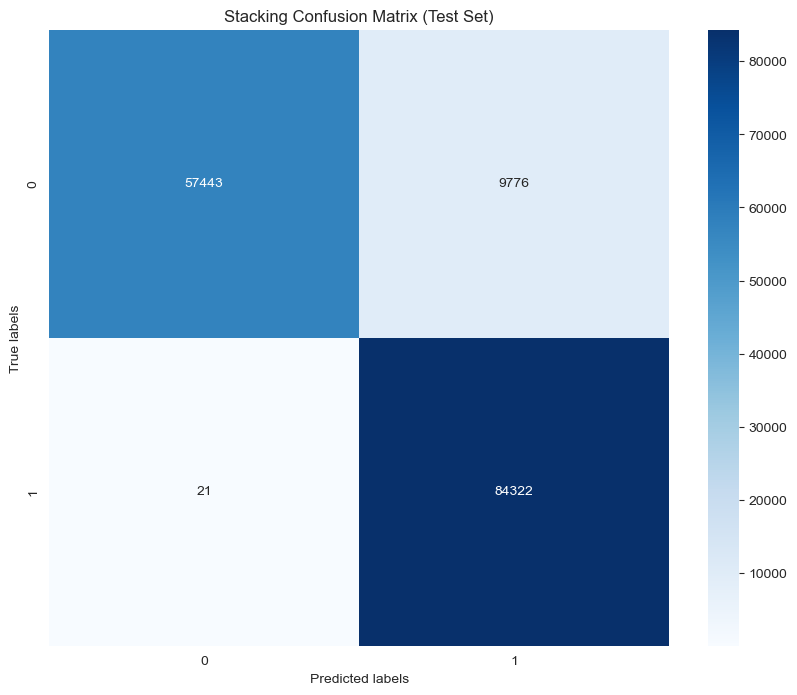

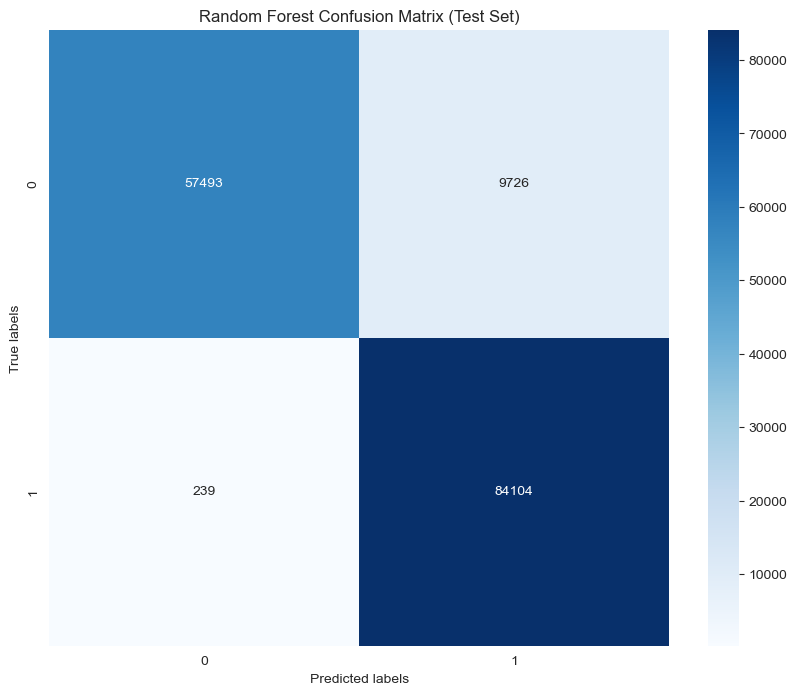

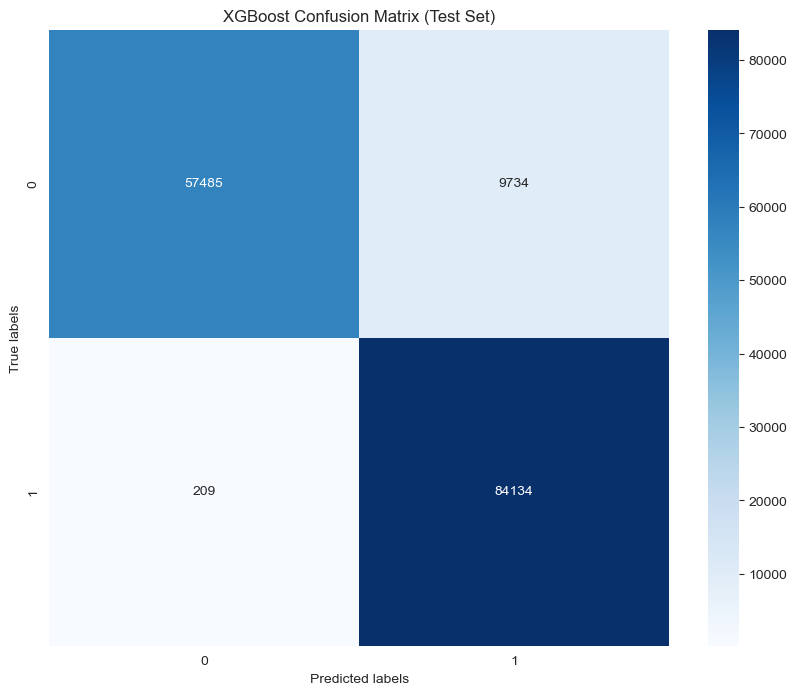

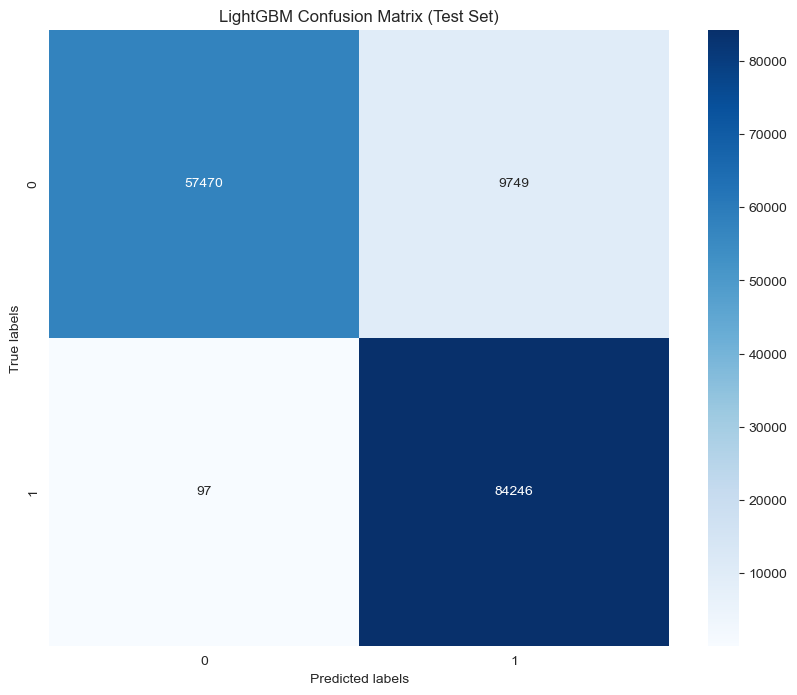

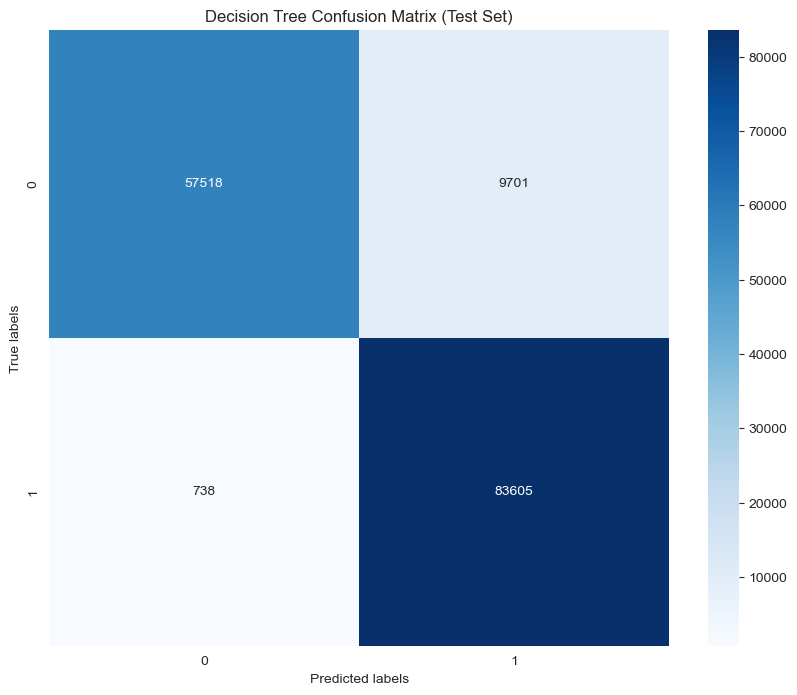

In [62]:
plot_confusion_matrix(y_test, y_test_stack, 'Stacking Confusion Matrix (Test Set)')
plot_confusion_matrix(y_test, y_test_pred_rf, 'Random Forest Confusion Matrix (Test Set)')
plot_confusion_matrix(y_test, y_test_pred_xgb, 'XGBoost Confusion Matrix (Test Set)')
plot_confusion_matrix(y_test, y_test_pred_lgbm, 'LightGBM Confusion Matrix (Test Set)')
plot_confusion_matrix(y_test, y_test_pred_tree, 'Decision Tree Confusion Matrix (Test Set)')

# 2nd Attempt with best params from base model for meta model

In [63]:
meta_model = lgb.LGBMClassifier(**lgbm_best_params)
second_stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, verbose=2)

In [64]:
second_stacked_model.fit(X_train, y_train)
beep()

Comparison of Accuracy
Stacking (Validation Set): 0.9356576610542817
Stacking (Test Set): 0.9353597867539357
2nd Stacking (Validation Set): 0.9356378176189862
2nd Stacking (Test Set): 0.9353136010345601
Comparison of Precision
Stacking (Validation Set): 0.896315764170446
Stacking (Test Set): 0.8961083126102574
2nd Stacking (Validation Set): 0.8962870374821723
2nd Stacking (Test Set): 0.8960669082561983
Comparison of Recall
Stacking (Validation Set): 0.99973188431702
Stacking (Test Set): 0.9997510166818823
2nd Stacking (Validation Set): 0.99973188431702
2nd Stacking (Test Set): 0.9997154476364369
Comparison of F1 Score
Stacking (Validation Set): 0.9452035117070986
Stacking (Test Set): 0.9450966986286784
2nd Stacking (Validation Set): 0.9451875385512339
2nd Stacking (Test Set): 0.9450577778774055
Comparison of ROC AUC
Stacking (Validation Set): 0.9277253628038726
Stacking (Test Set): 0.9271579731202446
2nd Stacking (Validation Set): 0.9277030627793426
2nd Stacking (Test Set): 0.927110435

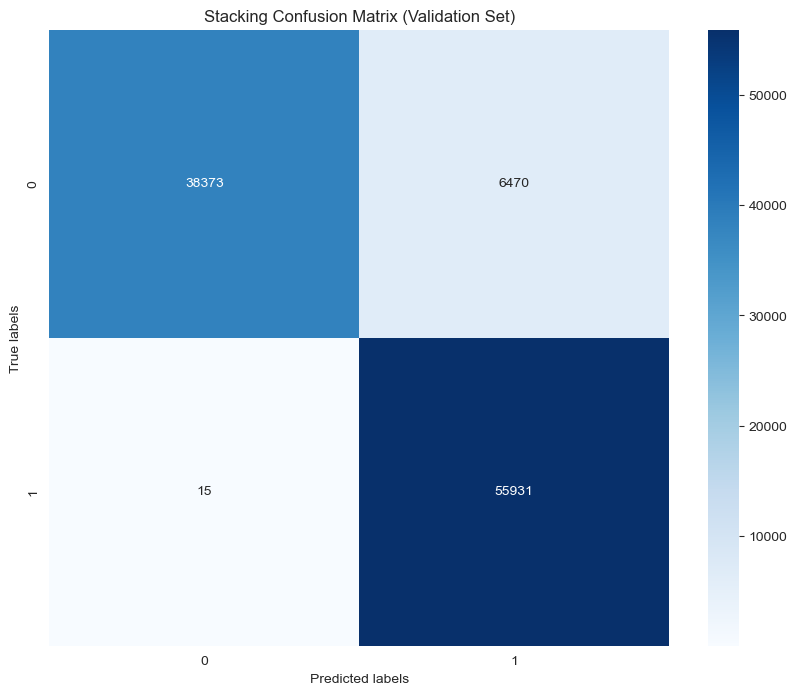

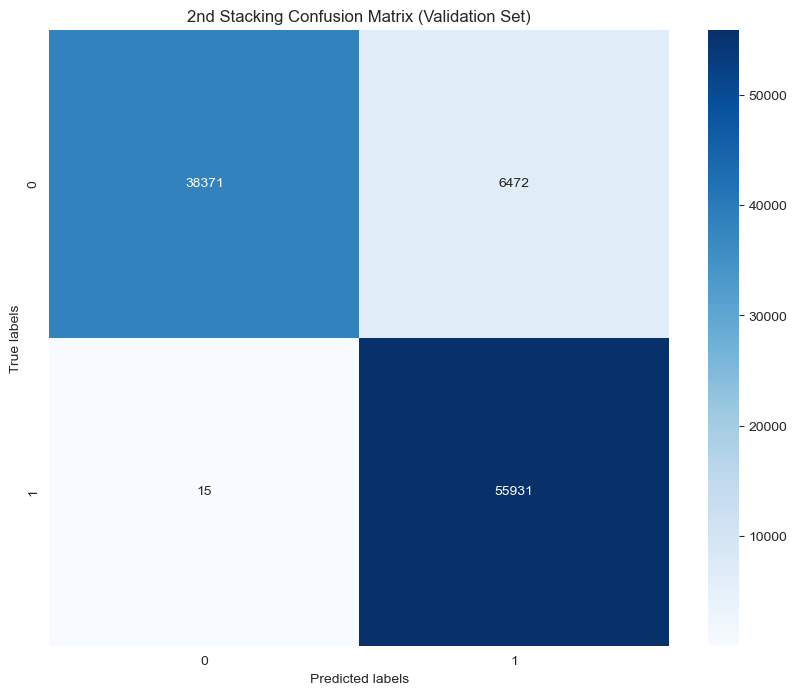

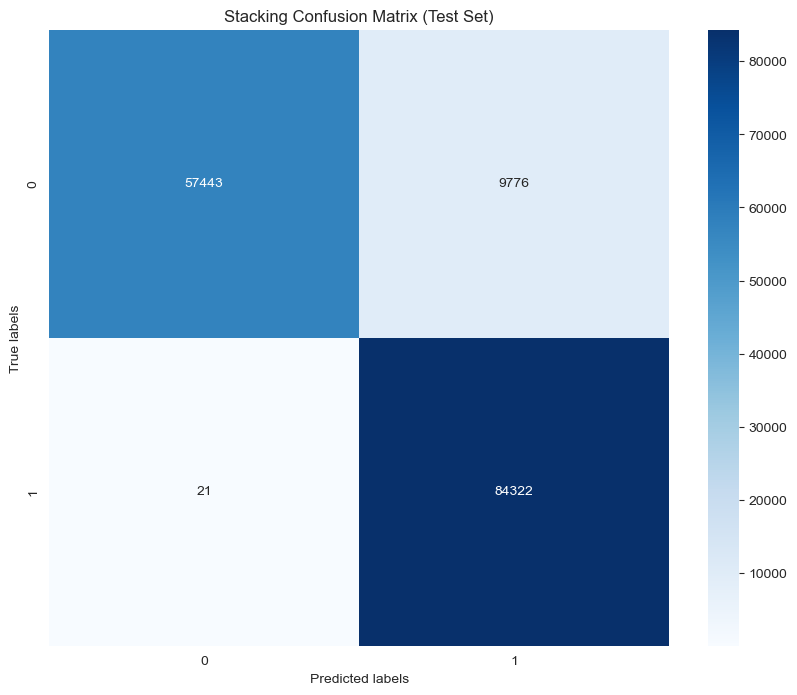

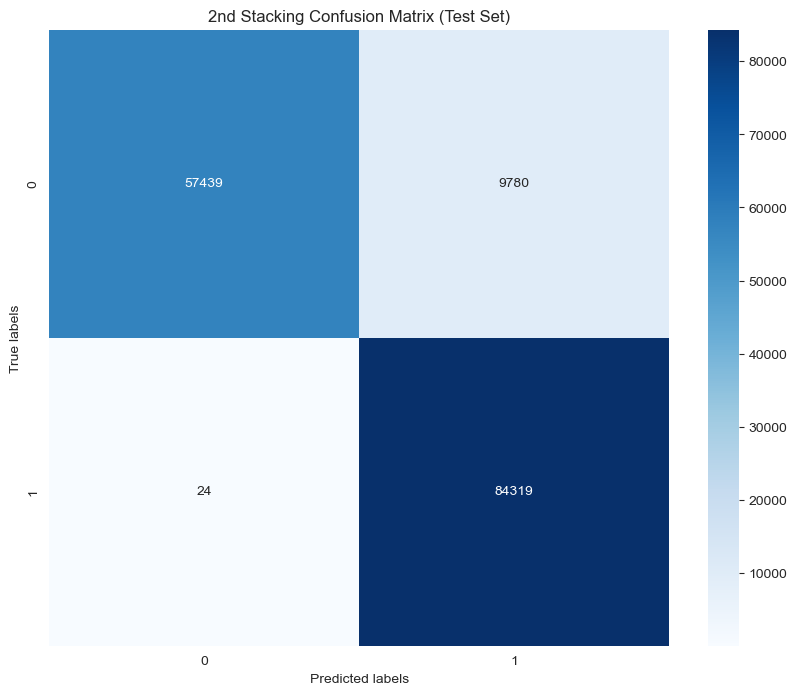

In [65]:
# Predict validation set and calculate performance matrices
y_val_stack = stacked_model.predict(X_val)
second_y_val_stack = second_stacked_model.predict(X_val)

y_test_stack = stacked_model.predict(X_test)
second_y_test_stack = second_stacked_model.predict(X_test)

# Calculate the performance metrics
y_val_stack_accuracy = accuracy_score(y_val, y_val_stack)
y_val_stack_precision = precision_score(y_val, y_val_stack)
y_val_stack_recall = recall_score(y_val, y_val_stack)
y_val_stack_f1 = f1_score(y_val, y_val_stack)
y_val_stack_roc_auc = roc_auc_score(y_val, y_val_stack)

second_val_stack_accuracy = accuracy_score(y_val, second_y_val_stack)
second_val_stack_precision = precision_score(y_val, second_y_val_stack)
second_val_stack_recall = recall_score(y_val, second_y_val_stack)
second_val_stack_f1 = f1_score(y_val, second_y_val_stack)
second_val_stack_roc_auc = roc_auc_score(y_val, second_y_val_stack)


y_test_stack_accuracy = accuracy_score(y_test, y_test_stack)
y_test_stack_precision = precision_score(y_test, y_test_stack)
y_test_stack_recall = recall_score(y_test, y_test_stack)
y_test_stack_f1 = f1_score(y_test, y_test_stack)
y_test_stack_roc_auc = roc_auc_score(y_test, y_test_stack)

second_test_stack_accuracy = accuracy_score(y_test, second_y_test_stack)
second_test_stack_precision = precision_score(y_test, second_y_test_stack)
second_test_stack_recall = recall_score(y_test, second_y_test_stack)
second_test_stack_f1 = f1_score(y_test, second_y_test_stack)
second_test_stack_roc_auc = roc_auc_score(y_test, second_y_test_stack)

models = ['Stacking (Validation Set)', 'Stacking (Test Set)', '2nd Stacking (Validation Set)', '2nd Stacking (Test Set)']
accuracy_values = [y_val_stack_accuracy, y_test_stack_accuracy, second_val_stack_accuracy, second_test_stack_accuracy]
precision_values = [y_val_stack_precision, y_test_stack_precision, second_val_stack_precision, second_test_stack_precision]
recall_values = [y_val_stack_recall, y_test_stack_recall, second_val_stack_recall, second_test_stack_recall]
f1_values = [y_val_stack_f1, y_test_stack_f1, second_val_stack_f1, second_test_stack_f1]
roc_auc_values = [y_val_stack_roc_auc, y_test_stack_roc_auc, second_val_stack_roc_auc, second_test_stack_roc_auc]

print_values(accuracy_values, models, 'Comparison of Accuracy')
print_values(precision_values, models, 'Comparison of Precision')
print_values(recall_values, models, 'Comparison of Recall')
print_values(f1_values, models, 'Comparison of F1 Score')
print_values(roc_auc_values, models, 'Comparison of ROC AUC')

plot_confusion_matrix(y_val, y_val_stack, 'Stacking Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_val, second_y_val_stack, '2nd Stacking Confusion Matrix (Validation Set)')
plot_confusion_matrix(y_test, y_test_stack, 'Stacking Confusion Matrix (Test Set)')
plot_confusion_matrix(y_test, second_y_test_stack, '2nd Stacking Confusion Matrix (Test Set)')

In [66]:
beep()